# Developing Features

In [10]:
import numpy as np
import pandas as pd
# for working with spark
import pyspark
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# pipeline to transform data
from pyspark.ml import Pipeline 
# to initiate spark
from pyspark.sql import SparkSession 
# to allow us to work with VectorAssembler
from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler,\
RegexTokenizer, StopWordsRemover, HashingTF, IDF, IDFModel
from pyspark.sql.types import FloatType
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.pipeline import PipelineModel

In [11]:
spark = SparkSession.builder \
    .appName("AABDW Assignment 3") \
    .getOrCreate()

# Data Cleaning

In [12]:
## Read in dataset of combined JSON files
df = pd.read_csv("assignment3_DIRTY.csv")
# Display the DataFrame
df.iloc[1]

aid                                                      39890863
title           A new podcast examines the perils of intense m...
url             https://www.npr.org/sections/health-shots/2024...
domain                                                    npr.org
votes                                                           1
user                                                      cempaka
posted_at                                     2024-04-01 04:13:32
comments                                                        0
source_title    A new podcast examines the perils of intense m...
source_text     Meditation can have dangerous effects on menta...
frontpage                                                   False
Name: 1, dtype: object

In [13]:
## Drop duplicate rows from the dataset
df=df.drop_duplicates()
## Checking for remaining duplicates based on the article ID 
## (some duplicate articles may not differ in all columns)
df["aid"].value_counts()

aid
40127574    3
40129904    2
40129833    2
40074331    2
40049985    2
           ..
40133700    1
40133687    1
40133680    1
40133670    1
40425156    1
Name: count, Length: 19515, dtype: int64

Some instances of the same article differ in their features. On closer inspection, it seems that most of these discrepancies are accounted for by the Financial Times changing editing the content of their _source_text_ over time.

In [14]:
## Compiling the remaining duplicate articles to investigate why they remained after drop.duplicates
# select and display articles which appear more than once
repeats = df["aid"].value_counts()!=1
df_reps = pd.DataFrame(repeats)
df_reps = df_reps.reset_index()
df_reps = df_reps.rename(columns={"count":"repeats"})
df_reps = df.merge(df_reps, on="aid")
df_reps[df_reps["repeats"]==True].head()

,aid,title,url,domain,votes,user,posted_at,comments,source_title,source_text,frontpage,repeats
644,40038439,Samsung's Texas plant will produce 2nm chips b...,https://www.ft.com/content/4124eb79-ea40-411d-...,ft.com,1,granter,2024-04-15 09:43:39,0,NaN,Samsung boosts Joe Biden’s chipmaking ambition...,False,True
645,40038439,Samsung's Texas plant will produce 2nm chips b...,https://www.ft.com/content/4124eb79-ea40-411d-...,ft.com,1,granter,2024-04-15 09:43:39,0,NaN,Samsung boosts Joe Biden’s chipmaking ambition...,False,True
1327,40049985,Copenhagen's 400-yr-old exchange burns down,https://www.ft.com/content/f9ec9d26-81eb-40d9-...,ft.com,5,mads,2024-04-16 09:27:53,0,NaN,Denmark’s historic stock exchange goes up in f...,True,True
1328,40049985,Copenhagen's 400-yr-old exchange burns down,https://www.ft.com/content/f9ec9d26-81eb-40d9-...,ft.com,5,mads,2024-04-16 09:27:53,0,NaN,Denmark’s historic stock exchange goes up in f...,True,True
2872,40070442,Effort to crack down on TikTok gains momentum ...,https://www.ft.com/content/c980675b-65a4-4f64-...,ft.com,1,TecoAndJix,2024-04-17 21:52:13,0,NaN,Push to crack down on TikTok gains momentum in...,False,True


In [15]:
## Double check to see that no duplicates remain
df = df.drop_duplicates(subset=["aid"]).reset_index(drop=True)
df["aid"].value_counts()

aid
39890845    1
40257972    1
40258037    1
40258016    1
40258005    1
           ..
40133575    1
40133574    1
40133558    1
40133555    1
40425156    1
Name: count, Length: 19515, dtype: int64

###  Cleaning up the _source_text_ variable

In [16]:
## function which tokenises and counts the number of words in the _source_text_ of each article
def num_of_words(df):
    df['word_count'] = df['source_text'].apply(lambda x : len(str(x).split(" ")))
    print(df[['source_text','word_count']].head())

In [17]:
num_of_words(df)

                                         source_text  word_count
0  A human–AI collaboration workflow for archaeol...        8583
1  Meditation can have dangerous effects on menta...        4234
2                                    reuters.com\n\n           1
3  Ancient Pollen Is Hiding in a Surprising Place...        2259
4  OSS backdoors: the folly of the easy fix - lca...         739


Text(0, 0.5, 'Number of Articles')

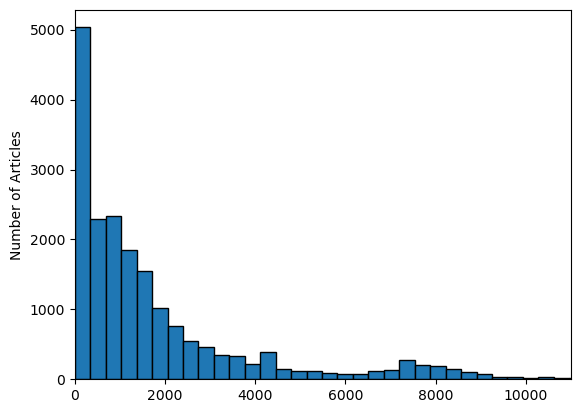

In [18]:
plt.hist(df['word_count'], bins=1000, edgecolor='black')
plt.xlim([0, 11000.])
plt.xticks([0.,  2000., 4000., 6000., 8000., 10000.])
plt.ylabel("Number of Articles")

Text(0, 0.5, 'Number of Articles')

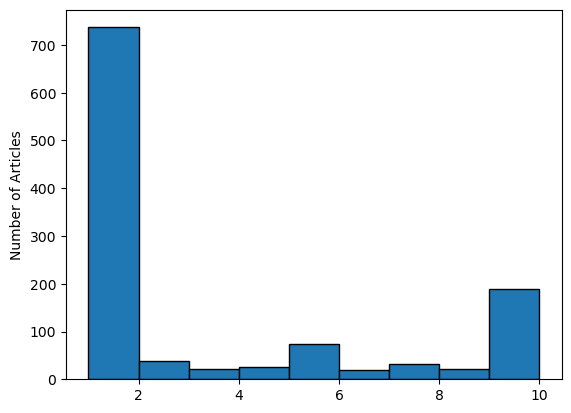

In [19]:
plt.hist(df.word_count[df.word_count<=10], bins=9, edgecolor='black')
plt.xticks([2., 4., 6., 8., 10.])
plt.ylabel("Number of Articles")

We see that some source_text variables have a very low word count, maybe indicating a problem with the data. 

In [20]:
low_word_count=df[df["word_count"]<=10]
low_word_count["domain"].value_counts().head()

domain
wsj.com            182
techcrunch.com     149
reuters.com        138
yahoo.com           49
fastcompany.com     17
Name: count, dtype: int64

In [21]:
low_word_count["frontpage"].value_counts()/sum(low_word_count["frontpage"].value_counts())

frontpage
False    0.803279
True     0.196721
Name: count, dtype: float64

In [22]:
low_word_count.iloc[1]

aid                                                      39891097
title           Microsoft, OpenAI plan $100B data-center proje...
url             https://www.reuters.com/technology/microsoft-o...
domain                                                reuters.com
votes                                                           1
user                                                   Judyrabbit
posted_at                                     2024-04-01 05:09:47
comments                                                        0
source_title                                          reuters.com
source_text                                       reuters.com\n\n
frontpage                                                   False
word_count                                                      1
Name: 12, dtype: object

In [23]:
df_nlwc = df.drop(low_word_count.index)
df_nlwc = df_nlwc.drop("word_count", axis = 1)
df_nlwc.to_csv("assignment3_full.csv", index=False)

# Exploratory Data Analysis

Text(0, 0.5, 'Number of Instances')

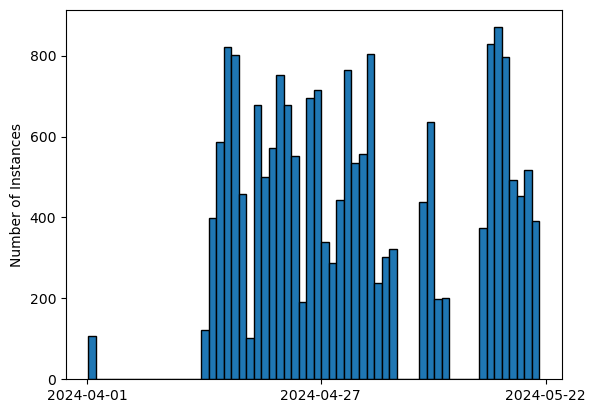

In [24]:
df['posted_at'] = pd.to_datetime(df['posted_at'])
plt.hist(df['posted_at'], bins=60, edgecolor='black')
plt.xticks([19814., 19840.,  19865.])
plt.ylabel("Number of Instances")

In [46]:
## Split Train/Test data
train, test= train_test_split(df_nlwc, test_size=0.2, random_state=1)
print("Training Dataset Count: " + str(train.shape[0]))
print("Test Dataset Count: " + str(test.shape[0]))

Training Dataset Count: 14684
Test Dataset Count: 3672


In [26]:
# proportions of positive and negative responses
train["frontpage"].value_counts()/sum(train["frontpage"].value_counts())

frontpage
False    0.824367
True     0.175633
Name: count, dtype: float64

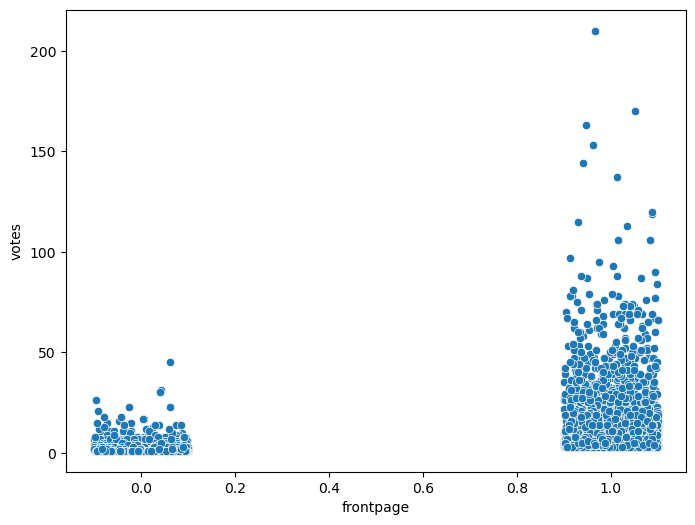

In [27]:
train_outlier=train[train.votes>500]
train_plot=train.drop(train_outlier.index)

# jitter was added to help with visualisation
jitter_strength = 0.1
jittered_frontpage = train_plot['frontpage'] + \
np.random.uniform(-jitter_strength, jitter_strength, size=train_plot.shape[0])

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=jittered_frontpage, y=train_plot['votes'])
plt.show()

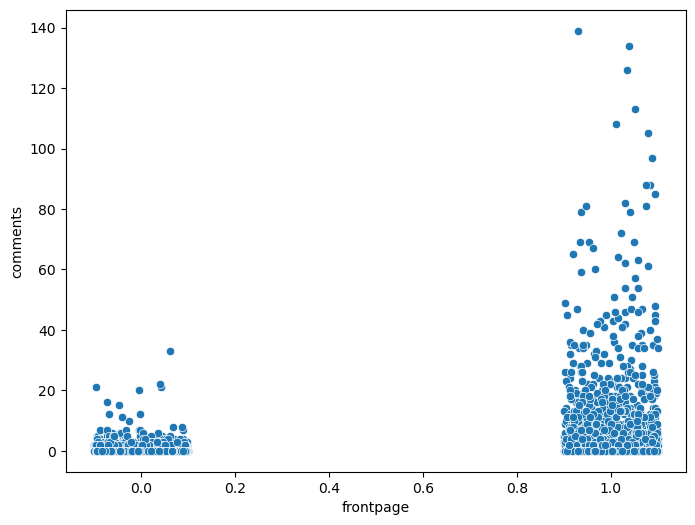

In [28]:
# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=jittered_frontpage, y=train_plot['comments'])
plt.show()

# Featurising  _'Title'_

Do all the subsetting _*before*_ using spark, otherwise we will use way too much memory and it will crash.

In [47]:
## turn our label into a binary variable
train['frontpage'] = train['frontpage'].astype(int)
test['frontpage'] = test['frontpage'].astype(int)
## use a sample of the data to use less memory (for working with source_text)
# train = train.sample(frac=0.1, random_state=1)
## subset by label and variable we wish to featurise, to use less memory
train = train[['frontpage','title', 'votes', 'comments']]
test = test[['frontpage','title', 'votes', 'comments']]

In [48]:
## create a spark DataFrame out of our pandas DataFrame
spark_train = spark.createDataFrame(train)
spark_test = spark.createDataFrame(test)
#spark_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=1)
## repartition the df (may make it easier to process)
spark_train = spark_train.repartition(4)
spark_test = spark_test.repartition(4)

In [49]:
## show contents of the DataFrame
spark_train.show(5)

+---------+--------------------+-----+--------+
|frontpage|               title|votes|comments|
+---------+--------------------+-----+--------+
|        0|Exposure to poor ...|    2|       0|
|        0|OpenSSF Warns of ...|    2|       0|
|        0|How do Spotify Co...|    1|       0|
|        0|FDA says 1 in 5 s...|    3|       0|
|        0|Sequoia commits t...|    2|       2|
+---------+--------------------+-----+--------+
only showing top 5 rows



In [50]:
## convert our variable of text into list of words
tokenizer = RegexTokenizer(inputCol="title", outputCol="title_words", pattern="\\W")

## adds a column of our tokenised words to df
spark_train_tokenised = tokenizer.transform(spark_train)

## show contents of the DF
spark_train_tokenised.select(['frontpage','title', 'title_words']).show(5)

+---------+--------------------+--------------------+
|frontpage|               title|         title_words|
+---------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|
|        0|   The Pen, Mightier|[the, pen, mightier]|
|        0|How to Exploit a ...|[how, to, exploit...|
|        0|        Westward Ho!|      [westward, ho]|
+---------+--------------------+--------------------+
only showing top 5 rows



In [51]:
## stopwords remove to remove common, uninformative words
stopwords_remover = StopWordsRemover(inputCol="title_words", outputCol="f_title_words")

## adds a column of the filtered words to df
spark_train_stopwordless = stopwords_remover.transform(spark_train_tokenised)

## print the contents of the DF
spark_train_stopwordless.select(['frontpage','title', 'title_words', 'f_title_words']).show(5)

+---------+--------------------+--------------------+--------------------+
|frontpage|               title|         title_words|       f_title_words|
+---------+--------------------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|[unearthing, apt4...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|[tesla, 2m, car, ...|
|        0|   The Pen, Mightier|[the, pen, mightier]|     [pen, mightier]|
|        0|How to Exploit a ...|[how, to, exploit...|[exploit, buffer,...|
|        0|        Westward Ho!|      [westward, ho]|      [westward, ho]|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [53]:
## Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="f_title_words",
                       outputCol="raw_features", 
                       numFeatures=256)

## adds raw tf features to the DF
featurized_data = hashing_tf.transform(spark_train_stopwordless)

## Inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="title_features")

idf_vectorizer = idf.fit(featurized_data)

## converting text to vectors
rescaled_data = idf_vectorizer.transform(featurized_data)

## display the top 20 rows
rescaled_data.select('frontpage','title', 'title_words', 'f_title_words', "title_features").show(5)

+---------+--------------------+--------------------+--------------------+--------------------+
|frontpage|               title|         title_words|       f_title_words|      title_features|
+---------+--------------------+--------------------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|[unearthing, apt4...|(256,[63,96,121,1...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|[tesla, 2m, car, ...|(256,[35,59,73,15...|
|        0|   The Pen, Mightier|[the, pen, mightier]|     [pen, mightier]|(256,[63,186],[3....|
|        0|How to Exploit a ...|[how, to, exploit...|[exploit, buffer,...|(256,[44,105,197]...|
|        0|        Westward Ho!|      [westward, ho]|      [westward, ho]|(256,[22,249],[4....|
+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [54]:
assembler = VectorAssembler(inputCols=['title_features', 'votes', 'comments'],outputCol="features")
rescaled_data = assembler.transform(rescaled_data)

In [55]:
#### TEST #### WITHOUT #### TEXT #### FEATURES ####
## Still achieves a very high predictive accuracy


# assembler = VectorAssembler(inputCols=['votes', 'comments'],outputCol="features")
# rescaled_data = assembler.transform(rescaled_data)

In [56]:
## model object
lr = LogisticRegression(featuresCol='features',
                        labelCol='frontpage',
                        family="auto",
                        maxIter=50)

## train model with default parameters
lrModel = lr.fit(rescaled_data)

In [ ]:
# Test-set Accuracy is :  0.9821321961620465 with the text features
# Test-set Accuracy is :  0.9884550155625812 without the text features

## Model Pipeline

In [58]:
# pipeline staging area
tokenizer = RegexTokenizer(inputCol="title", outputCol="title_words", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="title_words", outputCol="f_title_words")
hashing_tf = HashingTF(inputCol="f_title_words",
                       outputCol="raw_features", 
                       numFeatures=256)
idf = IDF(inputCol="raw_features", outputCol="title_features")
assembler = VectorAssembler(inputCols=['title_features', 'votes', 'comments'],outputCol="features")
lr = LogisticRegression(featuresCol='features',
                        labelCol='frontpage',
                        family="auto",
                        maxIter=50)

In [59]:
# pipeline including all steps in the featurisation process
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, assembler, lr])

In [60]:
# fitting the model using the pipeline defined previously
model=pipeline.fit(spark_train)

In [61]:
# save the model to a specified location, to be loaded from later
model_path = "C:\\Users\\Dillon\\Desktop\\spark\\notebooks\\models" ## YOUR PATH HERE ##
model.write().overwrite().save(model_path)

In [62]:
# loading the model to evaluate it on the test set
pred_model = PipelineModel.load(model_path)

In [63]:
# transforming the test set and making predictions
predictions = pred_model.transform(spark_test)

In [64]:
predictions.select("title", "votes", "comments", "probability", "prediction", "frontpage").show()

+--------------------+-----+--------+--------------------+----------+---------+
|               title|votes|comments|         probability|prediction|frontpage|
+--------------------+-----+--------+--------------------+----------+---------+
|Glitch on BepiCol...|    2|       0|[0.91989247679589...|       0.0|        0|
|Petflix, the Vide...|    2|       0|[0.97834281919763...|       0.0|        0|
|Reverse Engineeri...|    1|       0|[0.98335741258370...|       0.0|        0|
|  American Flag Sort|   16|       0|[1.00441332701935...|       1.0|        1|
|A Visit to id Sof...|    1|       0|[0.98063894842531...|       0.0|        0|
|Design Principles...|    2|       0|[0.93663699072590...|       0.0|        0|
|Mozilla commissio...|    1|       0|[0.98213224014309...|       0.0|        0|
|Littlejohn and th...|    1|       0|[0.97237696274965...|       0.0|        0|
|Party Like It's 1...|    1|       0|[0.95815858549980...|       0.0|        0|
|Video codec writt...|    2|       0|[0.

In [65]:
## to evalute model
evaluator = BinaryClassificationEvaluator(labelCol="frontpage")

## print test accuracy
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))

Test-set Accuracy is :  0.9823327218007916
